In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib widget
matplotlib.rc('font', size=18)
import uncertainties as unc
import scipy.special as ss
import xarray as xr

from tqdm.notebook import tqdm

import sys
sys.path.append('../')
import general_purpose.utilities as ut
import general_purpose.uplotlib as uplt
import general_purpose.cartopy_plots as cplt

from importlib import reload

import rea.reconstruct as rec

# View the files

In [14]:
eofs_re = np.load('EOFs_rescaled.npy')
eofs_re.shape

(51, 40, 90)

In [15]:
pcs_re = np.load('PCs_rescaled.npy')
pcs_re.shape

(1711, 51)

In [16]:
lm = np.load('landMask.npy')
lm.shape

(40, 90)

In [17]:
yw_rho = np.load('yw_rho.npy')
yw_sigma = np.load('yw_sigma.npy')

yw_rho.shape, yw_sigma.shape

((51, 240), (51,))

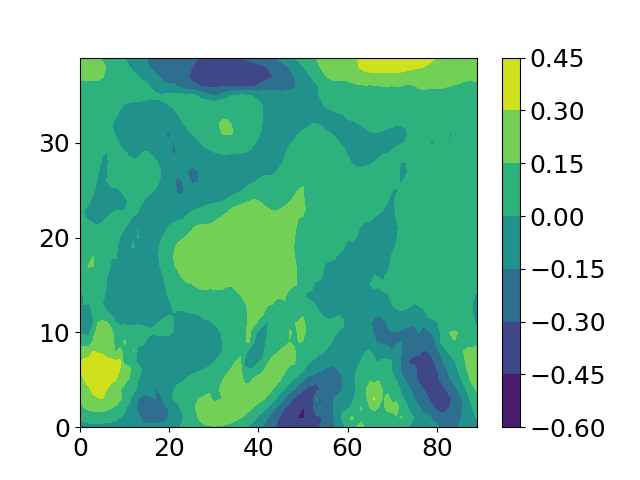

In [18]:
plt.figure()
plt.contourf(eofs_re[7])
plt.colorbar()

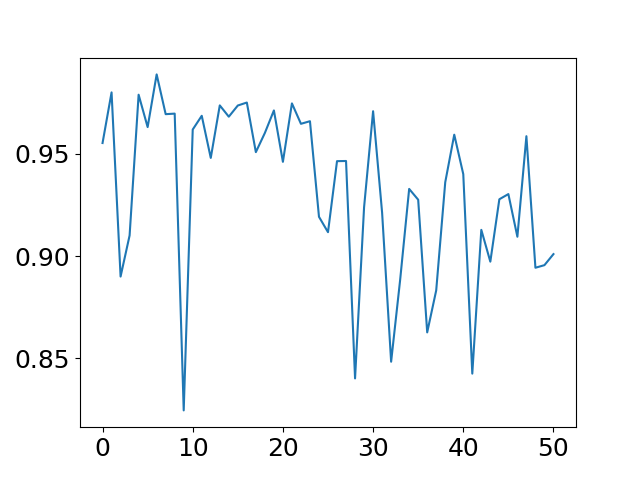

In [19]:
plt.figure()
plt.plot(yw_sigma)

In [21]:
yw_rho.shape

(51, 240)

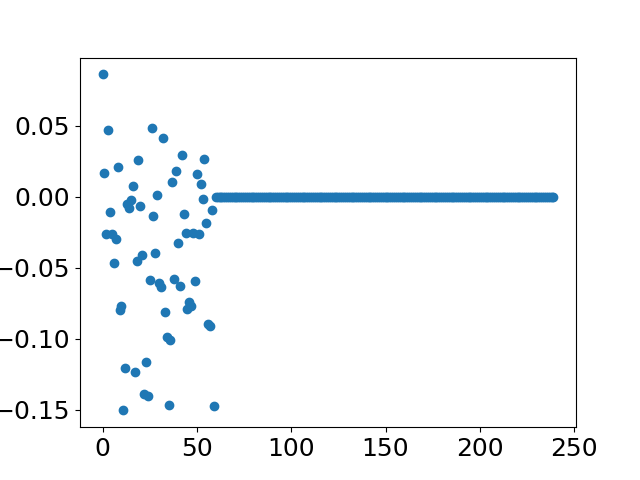

In [33]:
eof_id = 4

plt.close(4)
plt.figure(num=4)
_ = plt.scatter(np.arange(yw_rho.shape[1]), yw_rho[eof_id - 1])

### Plot the EOFs with the proper coordinates

In [ ]:
av = xr.load_dataset('__test__/e1.0000.averages.nc')

In [ ]:
av

In [ ]:
av['xt']

In [ ]:
av['yt']

In [ ]:
LON, LAT = np.meshgrid(av['xt'] - 360, av['yt'])

In [ ]:
plt.close(2)
fig = plt.figure(num=2, figsize=(9,4))
ax = fig.add_subplot(111, projection=cplt.ccrs.PlateCarree())

cplt.geo_plotter(ax, LON, LAT, eofs_re[0],
                 greenwich=True,
                 draw_gridlines=False, draw_labels=False,
                )

In [ ]:
plt.close('all')
i = 0
while True:
    lower = 9*i
    upper = min(9*(i+1), eofs_re.shape[0])
    if upper < lower:
        break
    ims = cplt.mfp(LON, LAT, eofs_re[lower:upper].transpose(1,2,0),
                   projections=cplt.ccrs.PlateCarree(), extents=None, titles=list(range(lower + 1,upper + 1)),
                   figsize=(12,6),
                   fig_num = 8 + i,
                   one_fig_layout=330,
                   colorbar='shared',
                   put_colorbar=False
                  )
    i += 1

# Effect of noise on the dynamics

In [2]:
def get_run(folder, iteration=None):
    if iteration is None:
        run = {'folder': folder, 'rec_dict': ut.json2dict(f'{folder}/reconstructed.json')}
    else:
        run = {'folder': folder, 'rec_dict': rec.reconstruct(f'{folder}/i{iteration:04d}')}
    
    run['abs_observables'] = {}
    run['rel_observables'] = {}
    for rname, r in run['rec_dict']['members'].items():
        last_segment_traj = np.load(f"{folder}/{run['rec_dict']['folders'][-1]}/{r['ancestry'][-1]}-traj.npy")
        first_segment_traj = np.load(f"{folder}/{run['rec_dict']['folders'][0]}/{r['ancestry'][0]}-traj.npy")
        run['abs_observables'][rname] = last_segment_traj[-1,1]
        run['rel_observables'][rname] = last_segment_traj[-1,1] - first_segment_traj[0,1]
        
    first_segment_traj = np.load(f"{folder}/{run['rec_dict']['folders'][0]}/{r['ancestry'][0]}-traj.npy")
    run['duration'] = last_segment_traj[-1,0] - first_segment_traj[0,0]
        
    return run

def compute_trajectories(run):
    folder = run['folder']
    rec_dict = run['rec_dict']
    rec_trajs = {}

    for rname, r in tqdm(rec_dict['members'].items()):
        traj = []
        for subfolder,e in zip(rec_dict['folders'], r['ancestry']):
            traj.append(np.load(f'{folder}/{subfolder}/{e}-traj.npy'))
        traj = np.concatenate(traj)

        rec_trajs[rname] = traj
    
    run['traj'] = rec_trajs
    
    return rec_trajs

def plot_traj(run, start=0, **kwargs):
    if 'traj' not in run:
        compute_trajectories(run)
    for traj in run['traj'].values():
        plt.plot(traj[start:,0]-traj[0,0], -traj[start:,1], **kwargs)

def expectation(run, func, mode='abs', **kwargs):
    _f = np.array([func(x, **kwargs) for x in run[f'{mode}_observables'].values()])
    _w = np.array([r['weight'] for r in run['rec_dict']['members'].values()])
    # _w = np.exp(-np.array([r['cum_log_escore'] for r in rec_dict['members'].values()]))
    # _n = np.exp(rec_dict['cum_log_norm_factor'])

    mean = np.mean(_f*_w)
    std = np.sqrt(np.mean((_f*_w)**2)/len(_w))

    return unc.ufloat(mean,std)

def f(x, a):
    return float(x>a)

def get_infos(folder):
    i = 0
    infos = {}
    while True:
        try:
            infos[i] = ut.json2dict(f'{folder}/i{i:04d}/info.json')
            i += 1
        except FileNotFoundError:
            break
            
    return infos


In [3]:
run_no_noise = get_run('../veros/__test__/r-0_minimal')
run_noise = get_run('__test__/rn-0_minimal')

compute_trajectories(run_no_noise)
_ = compute_trajectories(run_noise)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

## Plot the two trajectories

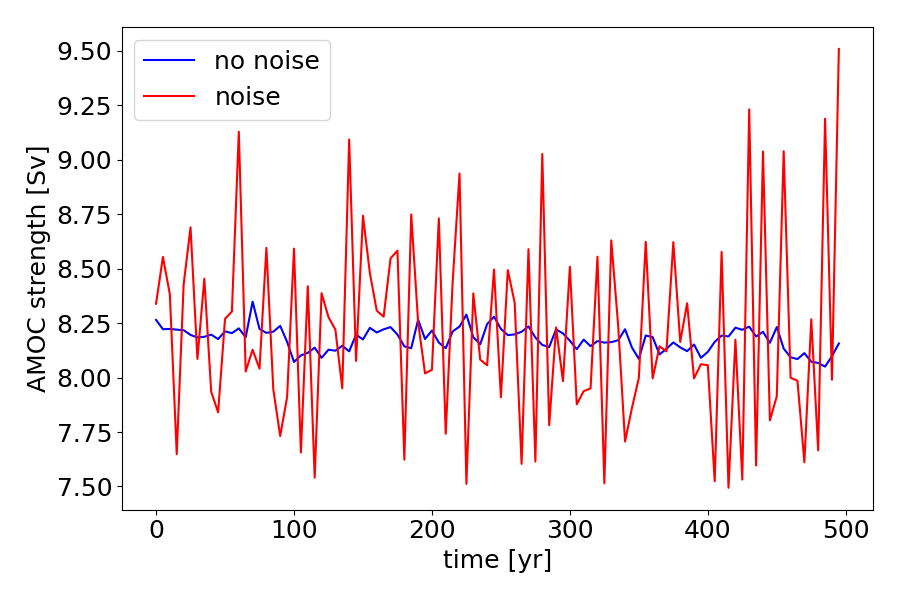

In [4]:
plt.close(1)
fig, ax = plt.subplots(num=1, figsize=(9,6))

plot_traj(run_no_noise, color='blue', label='no noise')
plot_traj(run_noise, color='red', label='noise')

plt.legend()

plt.xlabel('time [yr]')
plt.ylabel('AMOC strength [Sv]')

fig.tight_layout()

In [13]:
np.std(run_no_noise['traj']['r1'][...,1])

0.05338654080420439